# Лабораторная работа "Неодимовый лазер"

## В  настоящем блокноте представлена  программа для  выполнения следующих задач:<br>
### 1) Измерение времени жизни верхнего рабочего уровня 
### 2) Измерение времмени жизни фотона в резонаторе и первышения усиления над потерями 
### 3)   Измерение порога генерации

In [1]:

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths,savgol_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pandas as pd 
import copy
import math
import time as tm
from scipy.stats import t

In [2]:
data_path =  "Neodymium_lab_data"
save_path = "results"

In [3]:
def unpack(path, mod): 
    file = open(path + "\\" + mod + ".txt", 'r' )
    data = file.readlines()
    data = [line.rstrip().split(",") for line in data]
    settings = data[:4]
    del data[:5]
    data = np.array(data).astype("float")
    time = data[:,0]
    signal = data[:, 1]
    return  settings, time, signal

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]

def rand_error(data, conf_prob):
    mean = np.mean(data)
    n = len(data)
    #Доверительная вероятность  
    conf_prob = 0.66 
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return [mean, interval]
def generate_noise(noise):
    noise_len = noise[-1][1]
    print(noise_len)
    result = np.ones(noise_len)
    for i in range(len(noise)):
        result[noise[i][0]:noise[i][1]] = result[noise[i][0]:noise[i][1]] * noise[i][2]
    return result

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def plot_function(data,path, stage):
    stages = ["First", "Second", "Third", "Forth"]
    time_coef = 1e+3
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("{} pre-processing stage".format(str(stages[stage - 1])),{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
    ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
    ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
    ax.plot(data[0]* time_coef,  data[1], c = 'r', label = "original signal")
    ax.plot(data[0]* time_coef,  data[2], c = 'b', label = "signal after pre-processing")
    ax.legend(fontsize=18)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=15)
    ax.grid()
    plt.savefig(path + "\\" + "pre_processing_stage_{}.jpg".format(str(stage)))
    
def attenuation(time,signal,polinom_pow,window,path):
    res = savgol_filter(signal, window, polinom_pow)
    plot_function([time,signal,res],path,stage=1)
    res = signal - res 
    plot_function([time,signal,res],path,stage=2)
    res = abs(res - res.mean())
    plot_function([time,signal,res],path,stage=3)
    res = savgol_filter(res, window, polinom_pow)
    plot_function([time,signal,res],path,stage=4)
    
    [c,d],cov_1 = curve_fit(lambda x,c, d: c*np.exp(d*x),   time,  res, maxfev=5000)
#     print([c,d],cov_1, np.diag(cov_1), np.sqrt(np.diag(cov_1)))
    Delta_c, Delta_d = np.sqrt(np.diag(cov_1))
    print(d)
    return [res, d,c, Delta_d ]
    

In [4]:
mod = ["lifetime", "relax"]

Выполним первое задание 
### Измерение времени жизни верхнего рабочего уровня 

In [5]:
settings_lt, time_lt, signal_lt = unpack(data_path,"lifetime" )
#сдвинем время на 0 для удобства
time_lt =  time_lt -  time_lt[0]

Кристалл накачивался импульсно, длительность которого много больше времени жизни рабочего уровня. Чтобы определить время жизни верхнего уровня нужно апроксимировать сигнал сразу после выключения одного из импульсов  накачки экспонентой, число, обратное коэффициенту в показателе, будет нашим временем жизни.

Получим эту экспоненту $a\cdot e^{b\cdot t}$ В функцию curve_fit необходимо передавать такой срез, чтобы плато перед спадом не попадало в него, в нашем случае это все значения после 6000 индекса  

In [6]:
[a,b],cov = curve_fit(lambda x1,a, b: a*np.exp(b*x1),  time_lt[6000:],  signal_lt[6000:], maxfev=5000)
Delta_a, Delta_b = np.sqrt(np.diag(cov))

Весь сигнал  c аппроксимирующей кривой будет выглядеть так:

In [7]:
time_coef = 1e+3
ampl_coef = 1e+3

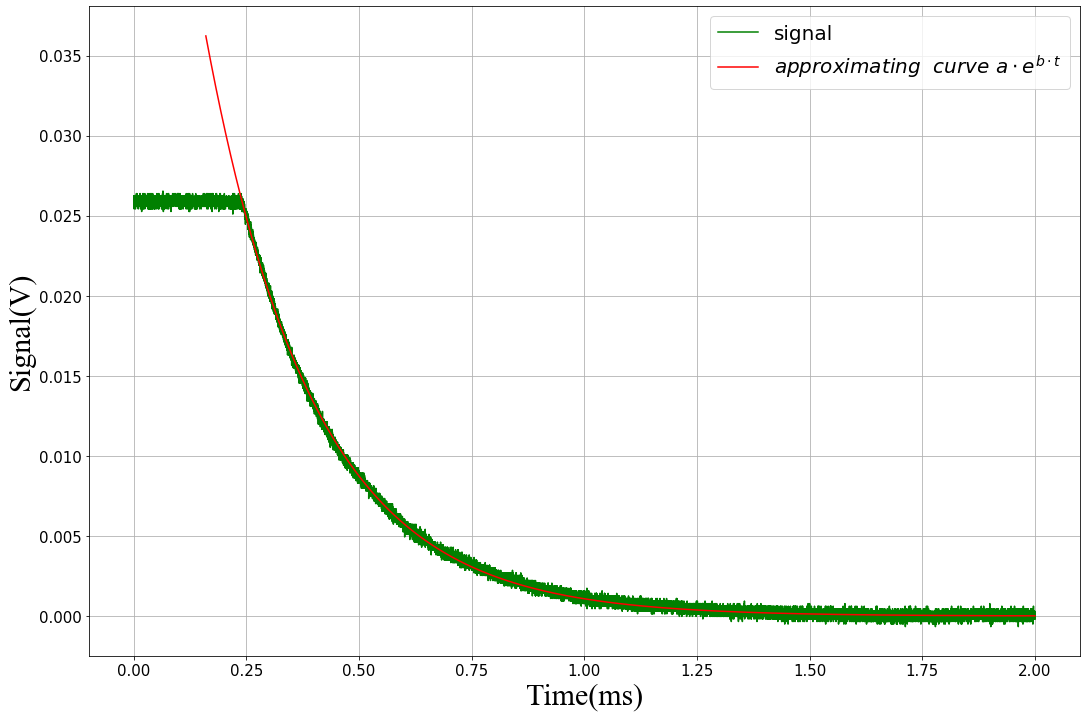

In [8]:

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_lt * time_coef,  signal_lt, c = 'g',label = "signal") 
ax.plot(time_lt[4000:]* time_coef, a*np.exp(b*time_lt[4000:]), c = 'r', label = "$approximating~~curve~a\cdot e^{b\cdot t}$") 
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
plt.savefig(save_path + "\\" + "full_graph_lifetime.jpg")

Коэффициент b найден $\Rightarrow~~ \tau_{life} = \frac{1}{b} ~~~~~~~~~~~~~\Delta \tau_{life} = \tau_{life}\cdot \frac{\Delta b}{b} = \tau_{life}\cdot \delta b $ 

In [9]:
tau_life_level = abs(1 / b) 
Delta_tau_life_level = tau_life_level*abs(Delta_b/b)
delta_tau_life_level = Delta_tau_life_level / tau_life_level

Результат,который лучше выписать отдельно<br>
$\tau_{life-level}~=~239.15\pm 6 мкc~~~~~~~~ \epsilon~=~ 0.02\%$


### Измерение времмени жизни фотона в резонаторе и первышения усиления над потерями 

In [10]:
settings_relax, time_relax, signal_relax = unpack(data_path,"relax" )
#сдвинем время на 0 для удобства
time_relax =  time_relax -  time_relax[0]

По экспоненте, по которой аппроксимируется сигнал,  мы определяем время затухания или декремент затухания.
По нему мы определяем превышение усиления над потерями.
Измерив период релаксационных колебаний мы узнаем время жизни фотона в резонаторе, руководствуясь формулами, которые являются следствием 
модели Статса-де-Марса:<br>
период осцилляций $\tau_{relax} = \sqrt{\frac{\tau_{life-level}\cdot \tau_{life-oor}}{\eta - 1}}$<br>
время затухания $\tau_{att} =  \frac{2\cdot\tau_{life-level}}{\eta}$


Найдём точки максимумов

In [11]:
 max_time_relax, max_signal_relax, max_ind_relax = find_max(
                                                             [time_relax, signal_relax], 
                                                              prominence = 0.02,
                                                              distance = 20
                                                             )
#Выбросим первые 5 точек для лучшего результата 
#  max_time_relax, max_signal_relax, max_ind_relax =  max_time_relax[5:], max_signal_relax[5:], max_ind_relax[5:]

Аппроксимируем их экспонентой

In [12]:
# [c,d],cov_1 = curve_fit(lambda x,c, d: c*np.exp(d*x),   max_time_relax,  max_signal_relax, maxfev=5000)
# print([c,d],cov_1, np.diag(cov_1), np.sqrt(np.diag(cov_1)))
# Delta_c, Delta_d = np.sqrt(np.diag(cov_1))
# approx_relax_time = np.linspace(0, max(time_relax),12000) 
# d

-17488.20795113488


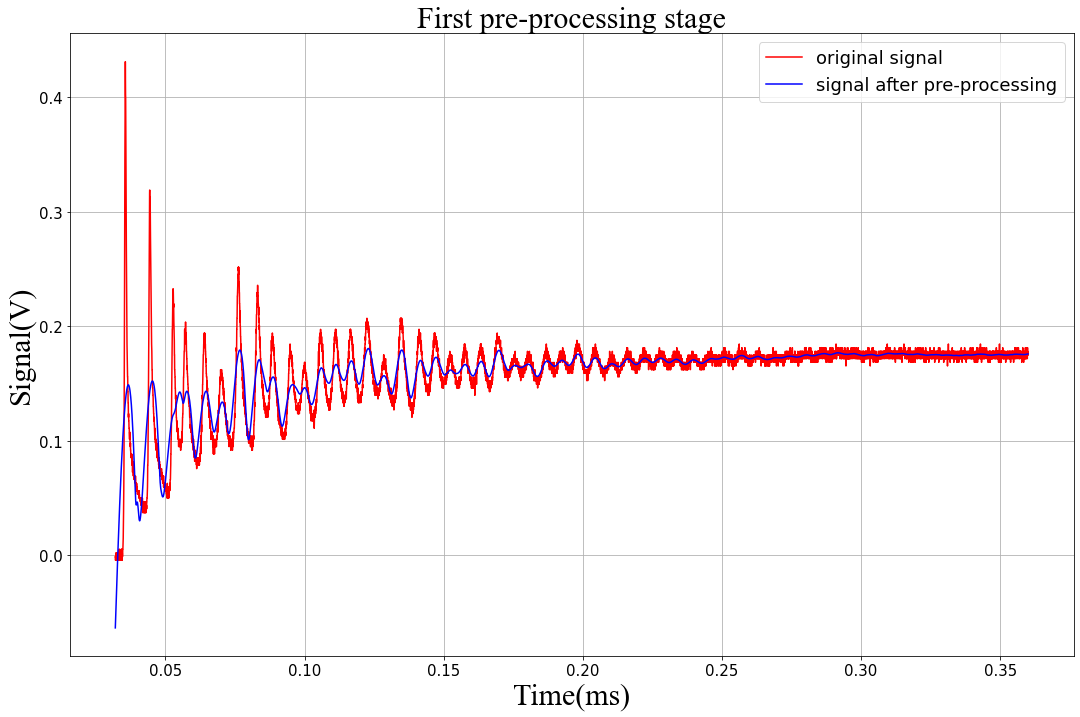

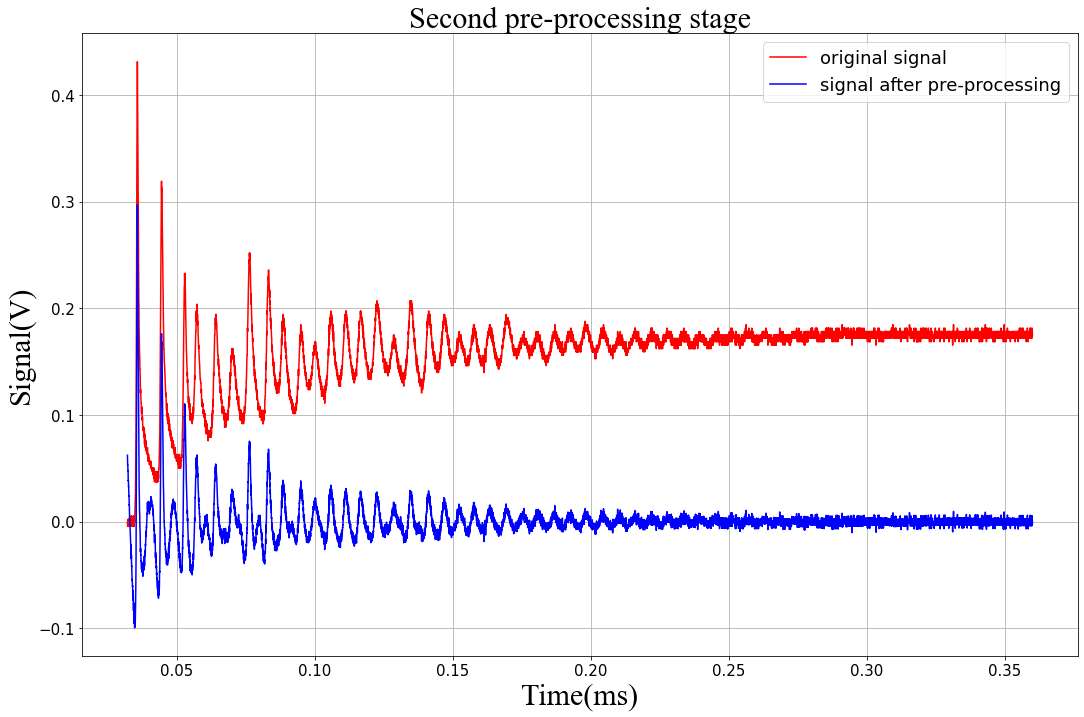

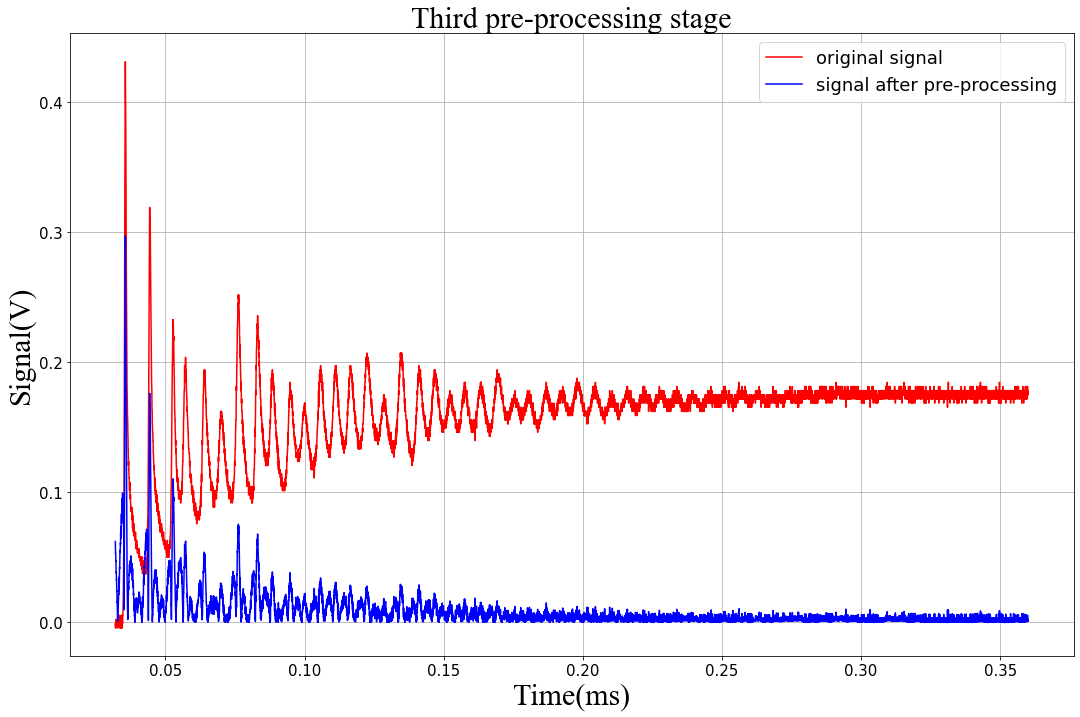

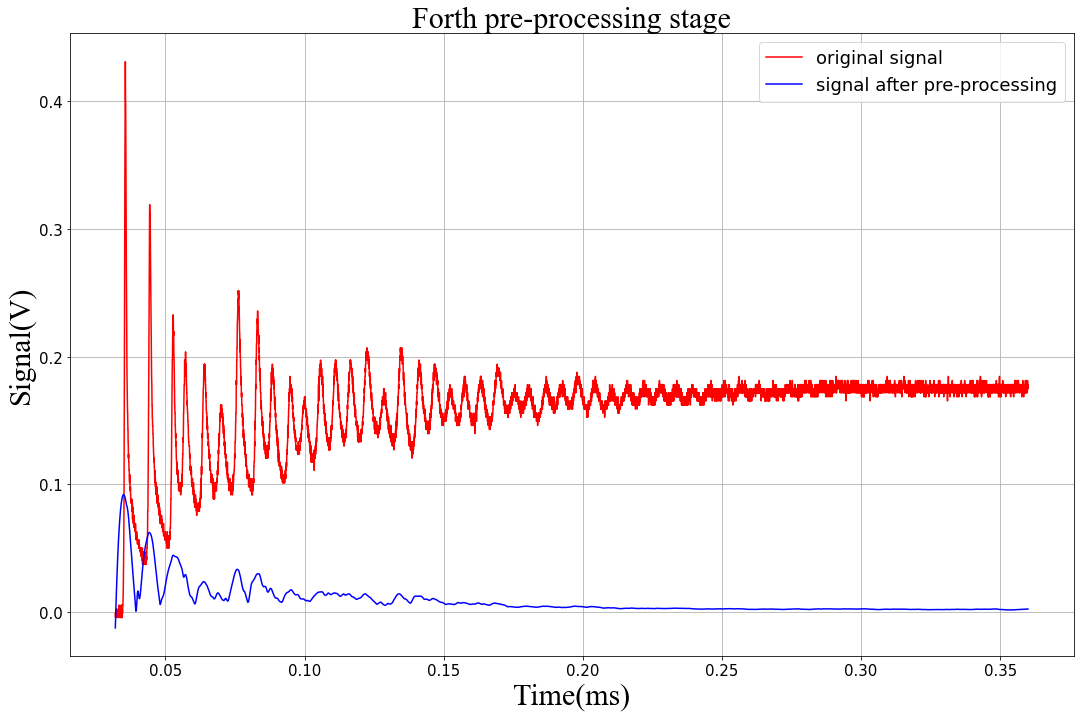

In [13]:
left_range = 800
right_range = 9000
pre_proc_signal_relax, d,c, Delta_d = attenuation(time_relax[left_range:right_range ], signal_relax[left_range:right_range ],polinom_pow=3,window=201,path=save_path)

In [14]:
tau_att = abs(1 / d)
Delta_tau_att = tau_att* abs(Delta_d / d)
delta_tau_att = Delta_tau_att / tau_att
print(tau_att, Delta_tau_att, delta_tau_att)

5.71813877553478e-05 6.678217797404466e-07 0.011679006158397922


Результат,который лучше выписать отдельно<br>
$\tau_{att}~=~57.1\pm 0.7 мкc~~~~~~~~ \epsilon~=~ 1\%$ - время затухания

In [15]:
eta_att = 2 * tau_life_level / tau_att
Delta_eta_att =  eta_att * math.sqrt(delta_tau_att**2 + delta_tau_life_level**2 )
delta_eta_att = Delta_eta_att / eta_att
print(eta_att, Delta_eta_att,delta_eta_att )

8.365132968529847 0.09772170506174362 0.01168202650566091


Определим превышение усиления над потерями $\eta_{att} = 2\tau_{life-level}/\tau_{att} ~=~ 8.36\pm 0.09) ~~~~~~\epsilon~=~ 1\%$

In [16]:
time_coef = 1e+3
right_range = 9000

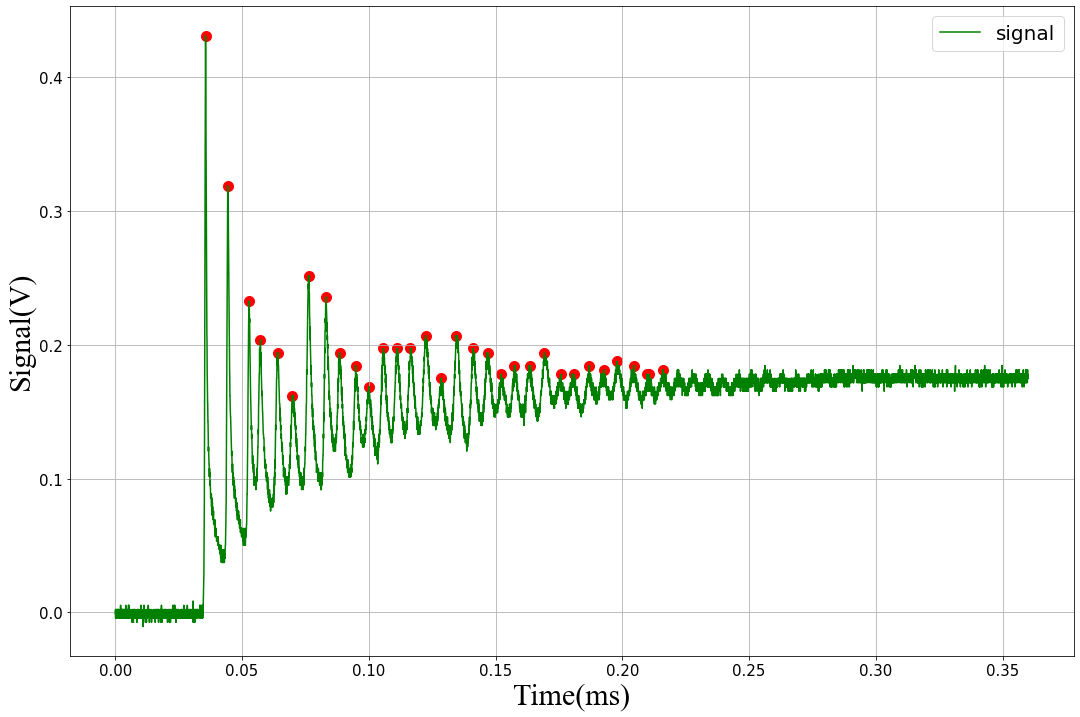

In [17]:
#первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.plot(time_relax[:right_range]*time_coef,  signal_relax[:right_range], c = 'g',label = "signal") 
# ax.plot(approx_relax_time[:right_range]*time_coef, c*np.exp(d*approx_relax_time)[:right_range], label = "$approximating~~curve~a\cdot e^{b\cdot t}$")
for i in range(len(max_ind_relax)):
    ax.scatter(max_time_relax[i]*time_coef, max_signal_relax[i],color='red', s=100, marker='o'  )
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
plt.savefig(save_path + "\\" + "full_graph_life_oor.jpg")

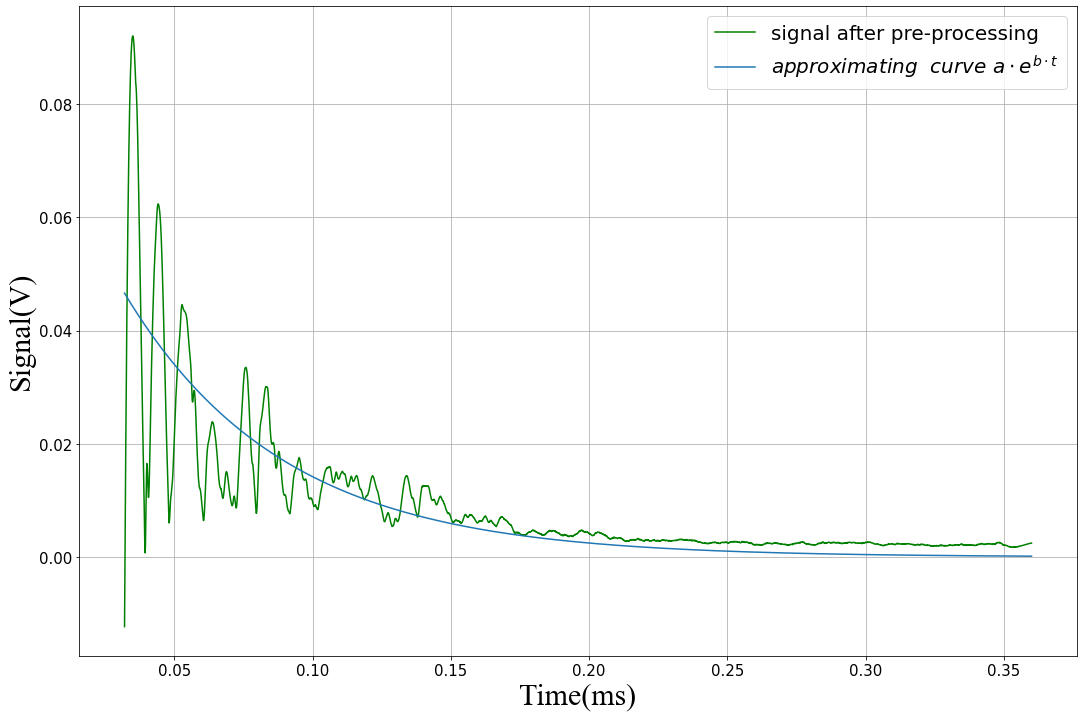

In [18]:

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.plot(time_relax[left_range:right_range]*time_coef,  pre_proc_signal_relax, c = 'g',label = "signal after pre-processing") 
ax.plot(time_relax[left_range:right_range]*time_coef, c*np.exp(d*time_relax[left_range:right_range]), label = "$approximating~~curve~a\cdot e^{b\cdot t}$")
# for i in range(len(max_ind_relax)):
#     ax.scatter(max_time_relax[i]*time_coef, max_signal_relax[i],color='red', s=100, marker='o'  )
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
plt.savefig(save_path + "\\" + "full_graph_preprocc_life_oor.jpg")

Нужно найти период релаксационных колебаний вблизи стационарного режима

In [19]:
tau_relax = np.diff(max_time_relax[len(max_ind_relax)//2:])
tau_relax, Delta_tau_relax = rand_error(tau_relax, conf_prob=0.99)
delta_tau_relax = Delta_tau_relax / tau_relax
print(tau_relax, Delta_tau_relax)

5.4399998e-06 3.3379034316678015e-07


$\tau_{relax} = 5.4 \pm 0.3 мкс ~~~~ \epsilon = 6\%$

Тогда время жизни фотона в резонаторе будет равно:<br>
$\tau_{life-oor} = \frac{\tau_{relax}^2\cdot(\eta_{att} - 1)}{\tau_{life-level}} ~~~~~~~~~~~~\Delta\tau_{life-oor}=\tau_{life-oor}\cdot\sqrt{(\delta\tau_{relax})^2 + (\frac{\delta\eta_{att}}{\eta_{att}-1})^2 + (\delta\tau_{life-level})^2}$

In [20]:
tau_life_oor = tau_relax**2 * (eta_att-1) / tau_life_level 
Delta_life_oor = tau_life_oor* math.sqrt(delta_tau_relax**2 + (Delta_eta_att / (eta_att-1))**2 + delta_tau_life_level**2)
delta_life_oor = Delta_life_oor / tau_life_oor
print(tau_life_oor,Delta_life_oor,delta_life_oor )

9.11340802944325e-07 5.72114652807706e-08 0.06277724545629251


$\tau_{life-oor} = 911\pm 50 нс~~~~~ \epsilon = 6\%$ 

### Измерение порога генерации

Введём значения сигнала, полученные при понижении тока питания лазера накачки. Все данные были получены с экрана осциллографа и экрана упраляющего пульта лазера. Кроме того отдельно запишем значения шума для интервалов, в виде [left_range_index, right_range_index, noise]

In [21]:
I_gen = np.array(
             [1.7, 1.65, 1.6, 1.55, 1.5, 1.45,
              1.4, 1.35, 1.3, 1.25, 1.2, 1.15, 
              1.1, 1.05, 1.0, 0.98, 0.96, 0.94, 0.92,
              0.91, 0.9, 0.89, 0.885, 0.880,
              0.875, 0.870]
            )
signal_gen = np.array(
                       [332.5, 315, 294.5, 279, 256,
                        240, 214, 187, 162.5, 138, 
                        125, 97.6, 74, 54.1, 40.6,
                        34, 26.9, 21.65, 15.55,
                        12.10, 8.8, 6.04, 4.74, 3.88,
                        2.4, 1.5] 
                       ) * 1e-3
noise_gen = [[0, 9, 7.5*1e-3], [9, 13, 5.2* 1e-3], [13, 15 ,3.3* 1e-3],[15, 20, 1.85* 1e-3],[20, 26, 0.86* 1e-3]]
noise_gen = generate_noise(noise_gen)

26


в качестве погрешности для тока возьмём последнюю цифру его значения

In [22]:
current_error = np.ones(len(I_gen ))*0.001

Для аппроксимации прямой возьмём серединные точки 

In [23]:
[k,n],cov_2 = curve_fit(lambda x,i, f: i * x + f,   I_gen[6:-2],  signal_gen[6:-2], maxfev=5000)
I_approx = np.linspace(I_gen.min(), I_gen.max(), 100)
signal_aprox = k * I_approx + n
Delta_k, Delta_n = np.sqrt(np.diag(cov_2))

Найдём точку, где прямая пересекает 0, это и будет пороговое значение тока, при котором сигнал пропадает

In [24]:
I_threshold = I_approx[find_nearest(signal_aprox, 0)]
I_threshold

0.8867676767676768

$I_{threshold} = 887\pm 1 mА$

In [25]:
ampl_coef = 1e+3

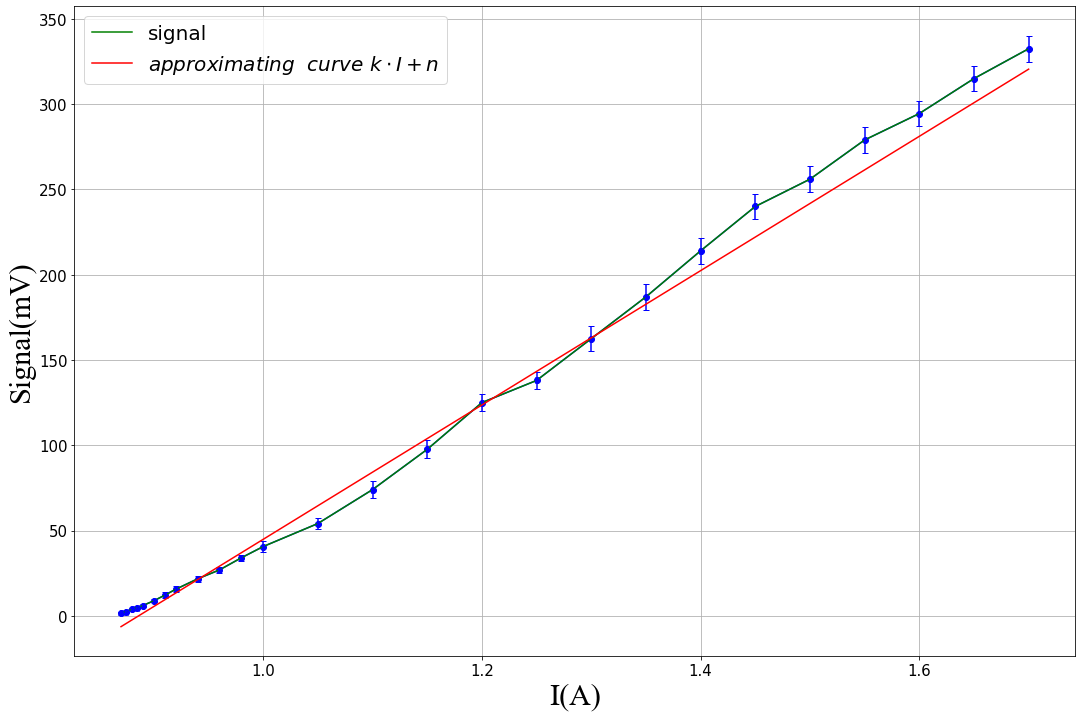

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(I_gen,  signal_gen*ampl_coef, c = 'green',label = "signal")
ax.errorbar(
            I_gen,  signal_gen*ampl_coef, xerr=current_error, yerr=noise_gen*ampl_coef,  
            c = 'blue', ecolor = "blue", fmt='-o',barsabove=True, ms=6, capsize = 3) 
ax.plot(I_approx, signal_aprox*ampl_coef, c="r",label = "$approximating~~curve~k\cdot I+n$")
ax.set_xlabel('I(A)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
plt.savefig(save_path + "\\" + "threshold.jpg")